In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

import sympy as sp

from pathlib import Path

from forceClass import Forces
from forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return -a*xData**b + c

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

def fit_data_poly(xData, yData, rank):
        tmp_poly = np.polyfit(xData, yData, rank)
        return np.poly1d(tmp_poly)

In [3]:
# Initial Parameters

# location of the data
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/Maertens_case'
# location of figures
figure_location = r'../../figures'

# Flags to handle data correctly
force_flag = 1
forceBin_flag = 1

# locations locations if mutliple locations
force_locations = np.array(['force_total', 'forces_top', 'forces_bottom'])
#force_locations = np.array(['forces'])

# cycle information
total_cycles = 7
averaged_cycles = 3

# density of the fluid
density = 998.2
# viscosity of the fluid
kinVisc = 1.31e-6

# dynamic parameters for fish
# coefficients for motion
carang_coeffs = [-0.825, 1.625]
ang_coeffs = [0.323, 0.310]
# wavenumber
lam = 1.0
k = 2 * np.pi / lam
# tail amplitude
amp = 0.1
# omega's related to strouhal
omega = np.array([1.5707963267949, 3.14159265358979, 7.85398163397448, 15.707963267949, 23.5619449019234, 31.4159265358979, 39.2699081698724, 47.1238898038469])
# fluid Velocity
U = 1.0
L = 1.0
# strouhal numbers tested
st = (2*amp)*(omega/(2*np.pi))/U

# Reynolds numbers tested
Re = np.array([4e3])


In [4]:
# Maertens Data
m_ang_freq = np.array([1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.4, 3.0, 4.0])
m_ang_omega = 2 * np.pi * m_ang_freq
m_ang_St = (2 * amp * m_ang_freq)/U
m_ang_Cp_BDIM = np.array([0.033678756, 0.054404145, 0.069948187, 0.116580311, 0.17357513, 0.240932642, 0.474093264, 1.002590674, 2.603626943])
m_ang_Cp_EBT = np.array([0.033678756, 0.054404145, 0.064766839, 0.116580311, 0.168393782, 0.230569948, 0.39119171, 0.691709845, 1.360103627])

m_carang_freq = np.array([1.2, 1.6, 1.8, 1.9, 2.1, 2.3, 2.6, 3.2, 4.0])
m_carang_omega = 2 * np.pi * m_carang_freq
m_carang_St = (2 * amp * m_carang_freq)/U
m_carang_Cp_BDIM = np.array([0.012953368, 0.054404145, 0.075129534, 0.101036269, 0.132124352, 0.17357513, 0.261658031, 0.520725389, 1.069948187])
m_carang_Cp_EBT = np.array([0.018134715, 0.054404145, 0.080310881, 0.101036269, 0.132124352, 0.17357513, 0.261658031, 0.453367876, 0.769430052])

In [5]:
force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()


if force_flag == 1:
    # get the individual cases
    cases = []
    force_case = force_paths[0].parts[-7]
    cases.append(force_case)
    for force_file in force_paths:
        if force_file.parts[-7] != force_case:
            cases.append(force_file.parts[-7])
            force_case = force_file.parts[-7]

    # make a nice dict of all the file names based on parent case
    force_caseDict = dict()
    for case in cases:
        force_caseDict[case] = {}
        for location in force_locations:
            force_caseDict[case][location] = []
            for force_file in force_paths:
                if force_file.parts[-7] == case and force_file.parts[-3] == location:
                    force_caseDict[case][location].append(force_file)

if forceBin_flag == 1:
    # get the individual cases
    cases = []
    forceBin_case = forceBins_paths[0].parts[-7]
    cases.append(forceBin_case)
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-7] != forceBin_case:
            cases.append(forceBins_file.parts[-7])
            forceBin_case = forceBins_file.parts[-7]

    # make a nice dict of all the file names based on parent case
    forceBin_caseDict = dict()
    for case in cases:
        forceBin_caseDict[case] = {}
        for location in force_locations:
            forceBin_caseDict[case][location] = []
            for forceBins_file in forceBins_paths:
                if forceBins_file.parts[-7] == case and forceBins_file.parts[-3] == location:
                    forceBin_caseDict[case][location].append(forceBins_file)

In [6]:
force_paths_total = []

if force_flag == 1:
    for case in force_caseDict:
        for path in force_caseDict[case][force_locations[0]]:
            force_paths_total.append(path)
    forces = [Forces(force_path, averaged_cycles, total_cycles, True, True, 'blackman', 51) for force_path in force_paths_total]

(-5.0, 5.0)

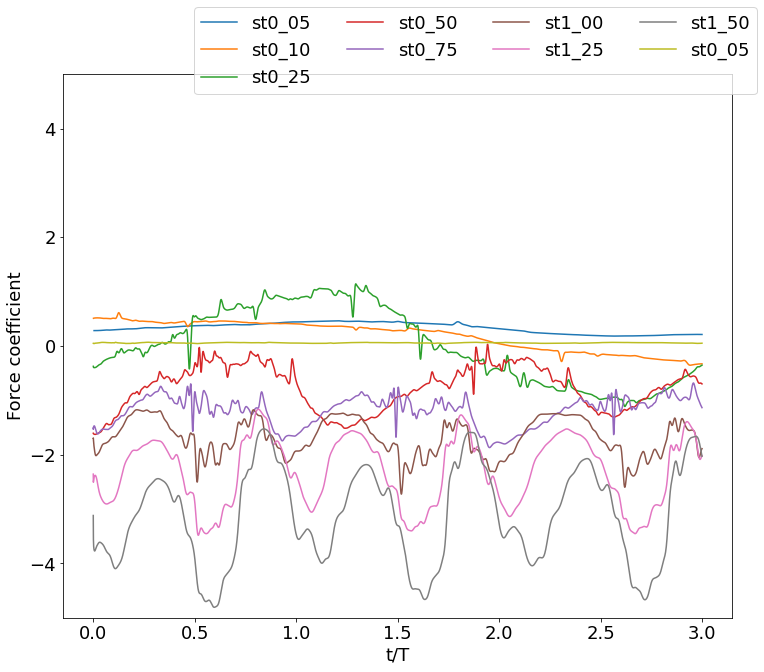

In [7]:
plt.rcParams.update({'font.size':18})

fig1, ax1 = plt.subplots(figsize=(12,10))

for force in forces[0:9]:
    ax1.plot(force.filteredForces['time']/force.filteredForces['time'][-1]*averaged_cycles, force.filteredForces['total']['x']/(density*U**2*L**2), label=force.specific_case)

ax1.set_xlabel('t/T')
ax1.set_ylabel('Force coefficient')
ax1.legend(ncol=4, bbox_to_anchor=(1.05, 1.14))
ax1.set_ylim([-5, 5])
#fig1.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

In [8]:
forceBin_paths_top = []
forceBin_paths_bottom = []

if forceBin_flag == 1:
    for case in forceBin_caseDict:
        for path in forceBin_caseDict[case][force_locations[1]]:
            forceBin_paths_top.append(path)
        for path in forceBin_caseDict[case][force_locations[2]]:
            forceBin_paths_bottom.append(path)    

forceBins_top = [ForceBins(forceBin_path, averaged_cycles, total_cycles, True, True, 'blackman', 51) for forceBin_path in forceBin_paths_top]
forceBins_bottom = [ForceBins(forceBin_path, averaged_cycles, total_cycles, True, True, 'blackman', 51) for forceBin_path in forceBin_paths_bottom]

In [9]:
for forceBin in forceBins_top:
    if forceBin.parent_case == 'carangiform_Re4e03':
        if forceBin.specific_case == 'st0_05':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[0], k)
        elif forceBin.specific_case == 'st0_10':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[1], k)
        elif forceBin.specific_case == 'st0_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[2], k)
        elif forceBin.specific_case == 'st0_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[3], k)
        elif forceBin.specific_case == 'st0_75':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[4], k)
        elif forceBin.specific_case == 'st1_00':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[5], k)
        elif forceBin.specific_case == 'st1_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[6], k)
        elif forceBin.specific_case == 'st1_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[7], k)
    else:
        if forceBin.specific_case == 'st0_05':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[0], k)
        elif forceBin.specific_case == 'st0_10':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[1], k)
        elif forceBin.specific_case == 'st0_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[2], k)
        elif forceBin.specific_case == 'st0_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[3], k)
        elif forceBin.specific_case == 'st0_75':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[4], k)
        elif forceBin.specific_case == 'st1_00':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[5], k)
        elif forceBin.specific_case == 'st1_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[6], k)
        elif forceBin.specific_case == 'st1_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[7], k)

for forceBin in forceBins_bottom:
    if forceBin.parent_case == 'carangiform_Re4e03':
        if forceBin.specific_case == 'st0_05':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[0], k)
        elif forceBin.specific_case == 'st0_10':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[1], k)
        elif forceBin.specific_case == 'st0_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[2], k)
        elif forceBin.specific_case == 'st0_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[3], k)
        elif forceBin.specific_case == 'st0_75':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[4], k)
        elif forceBin.specific_case == 'st1_00':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[5], k)
        elif forceBin.specific_case == 'st1_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[6], k)
        elif forceBin.specific_case == 'st1_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, carang_coeffs[0], carang_coeffs[1]]), omega[7], k)
    else:
        if forceBin.specific_case == 'st0_05':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[0], k)
        elif forceBin.specific_case == 'st0_10':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[1], k)
        elif forceBin.specific_case == 'st0_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[2], k)
        elif forceBin.specific_case == 'st0_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[3], k)
        elif forceBin.specific_case == 'st0_75':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[4], k)
        elif forceBin.specific_case == 'st1_00':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[5], k)
        elif forceBin.specific_case == 'st1_25':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[6], k)
        elif forceBin.specific_case == 'st1_50':
            forceBin.calcPowerCarangiform(density, np.array([amp, ang_coeffs[0], ang_coeffs[1]]), omega[7], k)

In [10]:
base_coeff = -0.065352

if forceBin_flag == 1:
    average_power_dict = dict()
    for case in forceBin_caseDict:
        average_power_dict[case] = {force_locations[1]:[], force_locations[2]:[], 'combined':[]}
        for forceBin in forceBins_top:
            if forceBin.parent_case == case:
                average_power_dict[case][force_locations[1]].append(forceBin.average_power)
        for forceBin in forceBins_bottom:
            if forceBin.parent_case == case:
                average_power_dict[case][force_locations[2]].append(forceBin.average_power)

        average_power_dict[case]['combined'] = (np.array(average_power_dict[case][force_locations[1]]) + 
                                                np.array(average_power_dict[case][force_locations[2]]))

if force_flag == 1:
    average_force_dict = dict()
    for case in force_caseDict:
        average_force_dict[case] = []
        for force in forces:
            if force.parent_case == case:
                T_t = (0.5 * (-force.averageFilteredForces['pressure']['x'] + np.abs(force.averageFilteredForces['pressure']['x'])) + 
                            0.5 * (force.averageFilteredForces['viscous']['x'] + np.abs(force.averageFilteredForces['viscous']['x'])))
                        
                D_t = (0.5 * (force.averageFilteredForces['pressure']['x'] - np.abs(force.averageFilteredForces['pressure']['x'])) + 
                            0.5 * (force.averageFilteredForces['viscous']['x'] - np.abs(force.averageFilteredForces['viscous']['x'])))

                F_t = np.array(T_t - D_t) / density
                
                
                average_force_dict[case].append(F_t)

In [11]:
average_power_fit = {}
average_force_fit = {}
zero_strouhal = {}

for case in force_caseDict:
    average_power_fit[case] = {}
    average_force_fit[case] = {}
    
    if forceBin_flag == 1:
        case_power_fit = fit_data_poly(st, np.array(average_power_dict[case]['combined']), 2)
        average_power_fit[case]['fit'] = case_power_fit
        average_power_fit[case]['roots'] = case_power_fit.r

    if force_flag == 1:
        case_force_fit = fit_data_poly(st, np.array(average_force_dict[case])- base_coeff, 2)
        case_power_zero = fit_data_poly(np.array(average_force_dict[case]) - base_coeff, st, 2)
        average_force_fit[case]['fit']= case_force_fit
        average_force_fit[case]['roots'] = case_force_fit.r
        
    zero_strouhal[case] = case_power_zero(0)

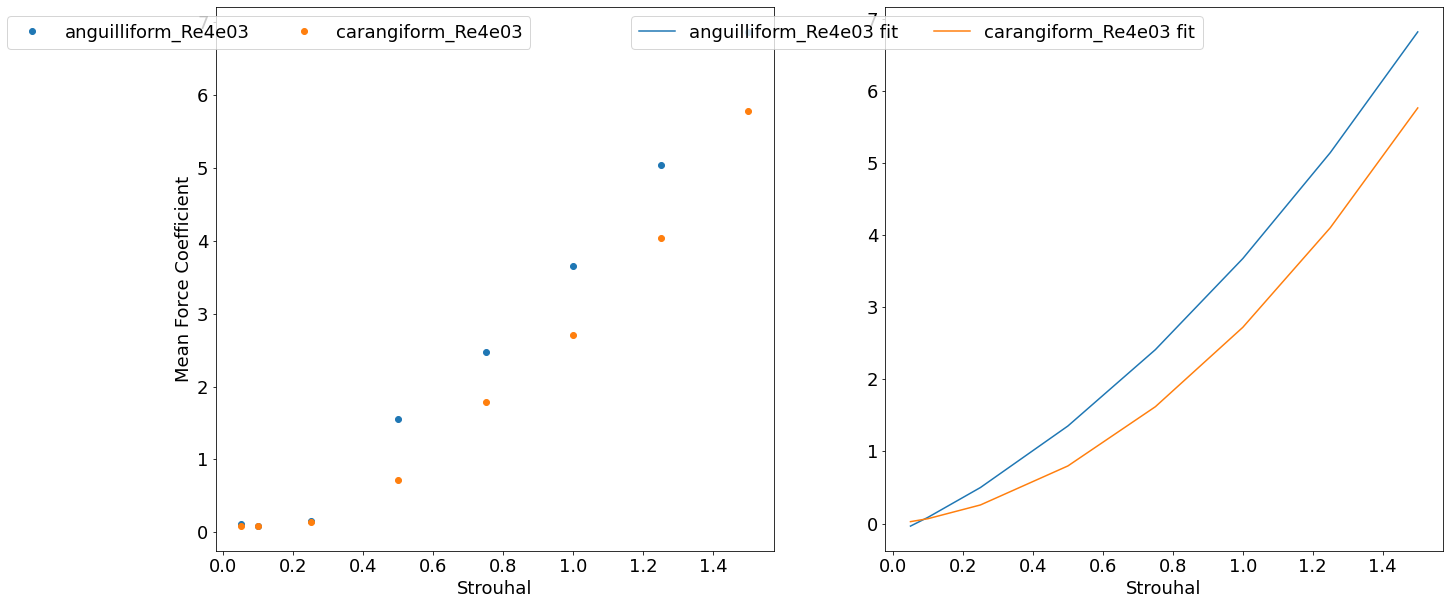

In [12]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))
for case in average_force_dict:
    ax1.plot(st, np.array(average_force_dict[case]) - base_coeff, 'o', label = case)
    ax2.plot(st, np.array(average_force_fit[case]['fit'](st)), label = case + ' fit')


ax1.set_xlabel('Strouhal')
ax2.set_xlabel('Strouhal')
ax1.set_ylabel('Mean Force Coefficient')
ax1.legend(ncol=2, bbox_to_anchor=(0.58, 1.0))
ax2.legend(ncol=2, bbox_to_anchor=(0.585, 1.0))
#ax1.set_ylim([-1.25, 0.25])
#ax2.set_ylim([-1.25, 0.25])
#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

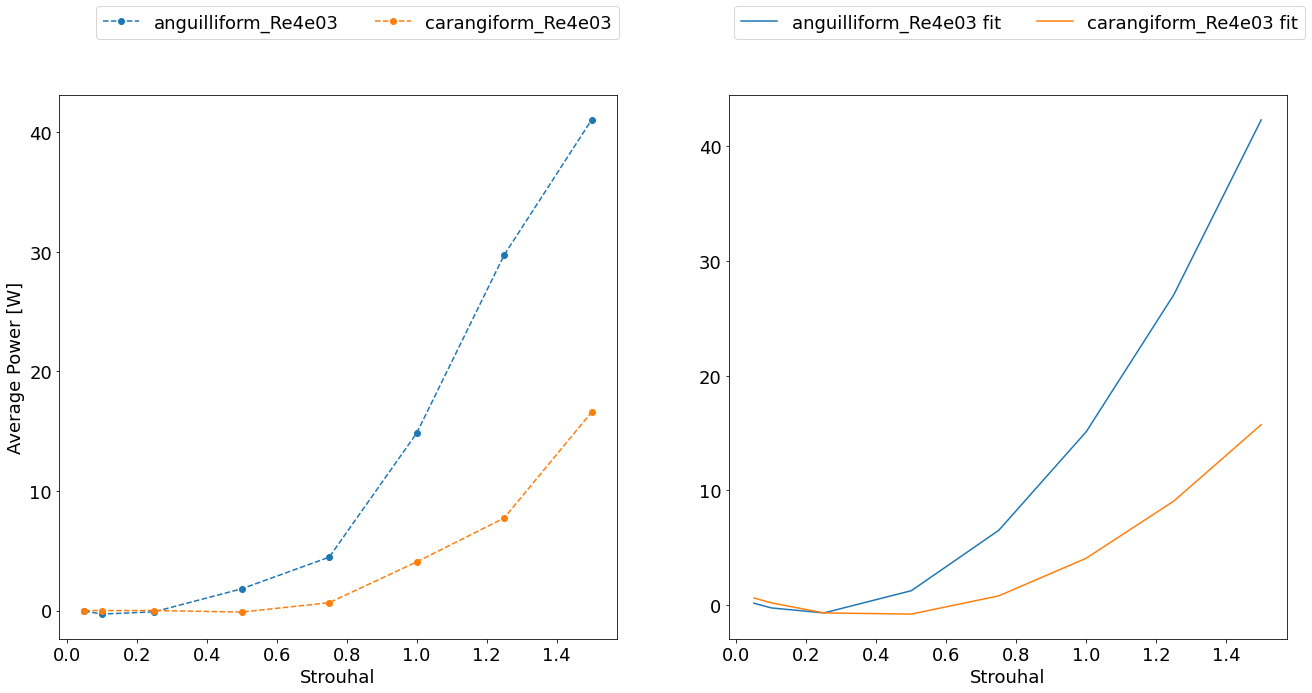

In [13]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))
for case in average_force_dict:
    ax1.plot(st, average_power_dict[case]['combined'], 'o--', label = case)
    ax2.plot(st, average_power_fit[case]['fit'](st), label = case + ' fit')


ax1.set_xlabel('Strouhal')
ax2.set_xlabel('Strouhal')
ax1.set_ylabel('Average Power [W]')
ax1.legend(ncol=3, bbox_to_anchor=(1.02, 1.18))
ax2.legend(ncol=3, bbox_to_anchor=(1.05, 1.18))
#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

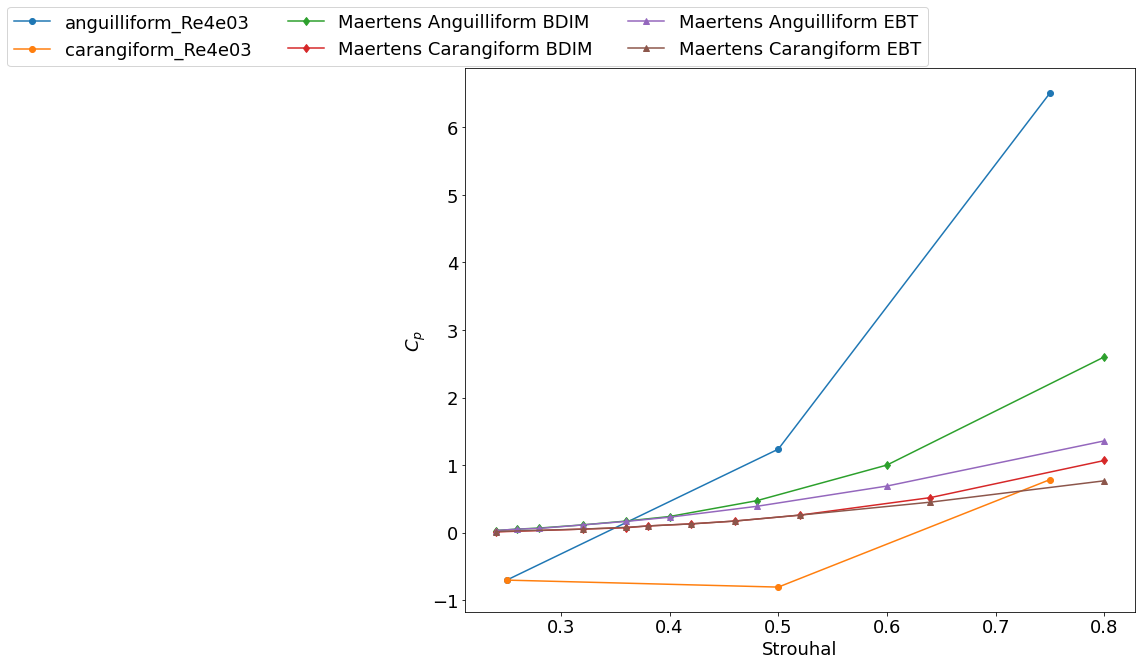

In [14]:
fig4, ax4 = plt.subplots(figsize=(12,10))
for case in average_force_dict:
    ax4.plot(st[2:5], np.array(average_power_fit[case]['fit'](st[2:5])), 'o-', label = case)

ax4.plot(m_ang_St, m_ang_Cp_BDIM, 'd-', label='Maertens Anguilliform BDIM')
ax4.plot(m_carang_St, m_carang_Cp_BDIM, 'd-', label='Maertens Carangiform BDIM')
ax4.plot(m_ang_St, m_ang_Cp_EBT, '^-', label='Maertens Anguilliform EBT')
ax4.plot(m_carang_St, m_carang_Cp_EBT, '^-', label='Maertens Carangiform EBT')

ax4.set_xlabel('Strouhal')
ax4.set_xlabel('Strouhal')
ax4.set_ylabel('$C_p$')
#ax4.set_ylim([-0.5, 5])
ax4.legend(ncol=3, bbox_to_anchor=(0.705, 1.13))

#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

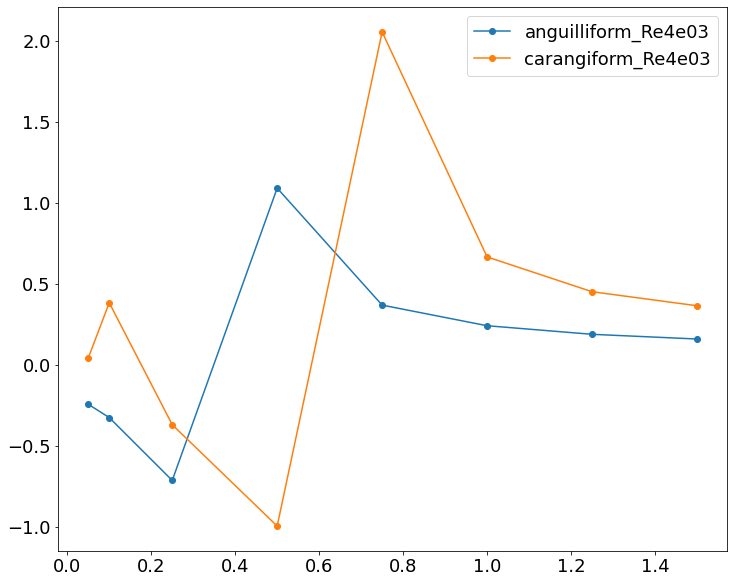

In [15]:
# calculating the net efficiency
fig5, ax5 = plt.subplots(figsize=(12,10))

for case in average_force_dict:
    Pin = np.array(average_power_fit[case]['fit'](st))
    Tn = np.array(average_force_fit[case]['fit'](st))
    eff_n = Tn * U / Pin

    ax5.plot(st, eff_n, 'o-', label=case)

ax5.legend()